# Manuscript figure 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import polars as pl
import polars.selectors as cs
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt
import gzip
from scipy import stats
pl.Config.set_fmt_str_lengths(50)
warnings.filterwarnings('ignore')
from upsetplot import generate_counts, plot, UpSet

In [6]:
fig_dir = "../../results/manuscript_figures/figure2/"

## Figure 2B PIRS distribution

In [30]:
screen_OE = pl.read_csv(os.path.join(fig_dir, "screen_labels_OE.tsv.gz"), separator="\t", has_header=False)

In [31]:
screen_OE = screen_OE.group_by("column_1", "column_2", "column_3").agg("column_4").with_columns(
	pl.when(pl.col("column_4").list.join(",").str.contains("PLS")).then(pl.lit("Known promoter"))
	.when(pl.col("column_4").list.join(",").str.contains("ELS")).then(pl.lit("Known enhancer"))
	   .otherwise(pl.lit("Unknown")).alias("type")
)

In [34]:
screen_OE.height

9504

In [33]:
fig = px.pie(screen_OE#.filter((pl.col("adj.P.Val") < 0.05)).sort("logFC", descending=True).head(10000)
			 .to_pandas(), names='type', title='Interacting elements found in ENCODE SCREEN', width=700, height=500, color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()
pio.write_image(fig, os.path.join(fig_dir,"known_elements_in_screen.pdf"), format="pdf")

## P-CRE length distributions

In [2]:
promoters = pl.read_csv('promoter_lengths.txt.gz', has_header=False, separator='\t', new_columns=["sequence length"]).with_columns(type=pl.lit("promoter"))
non_promoters = pl.read_csv('non_promoter_lengths.txt.gz', has_header=False, separator='\t', new_columns=["sequence length"]).with_columns(type=pl.lit("non-promoter"))
both = pl.concat([promoters, non_promoters])

In [3]:
both.head()

sequence length,type
i64,str
263,"""promoter"""
800,"""promoter"""
754,"""promoter"""
495,"""promoter"""
636,"""promoter"""


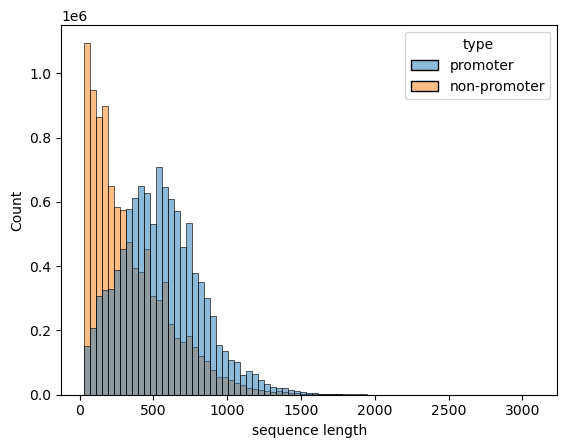

In [4]:
sns.histplot(both, x="sequence length", bins=75, hue='type')
plt.savefig("p-cre-lengths.pdf", format="pdf")

## Overlaps other datasets

In [3]:
import pandas as pd

# Create a list of tuples for the MultiIndex
tuples = [
    (True, False,  False),
    (True, True, False),
    (True, False,  True),
    (False, True,  False),
    (False, False, True)
]

# Create the MultiIndex
index = pd.MultiIndex.from_tuples(tuples, names=['capture Hi-C', 'Hi-C', 'H3k4me3 HiChIP'])

chic_total = 9592 - 125 - 857
hic_total = 470 - 125
plac_total = 4905 - 857

# Create the Series
values = [chic_total, 125, 857, hic_total, plac_total]
series = pd.Series(values, index=index, name='value')


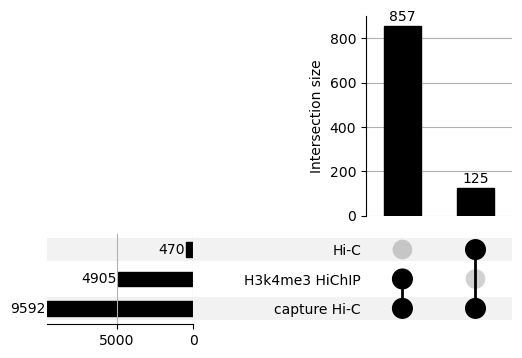

In [4]:
fig = plt.figure(figsize=(6, 4))
upset = UpSet(series, subset_size="sum", show_counts=True, min_degree=2, element_size=None)


upset.plot(fig=fig)
#plot(series, show_counts=True, fig=fig, totals_plot_elements=3, element_size=None)
# Manually add the totals
# for ax in fig.axes:
#     if ax.get_position().x0 < 0.2:  # Adjust the threshold as needed
#         ax.remove()

plt.savefig("dataset-overlaps.pdf", format="pdf", bbox_inches = 'tight')

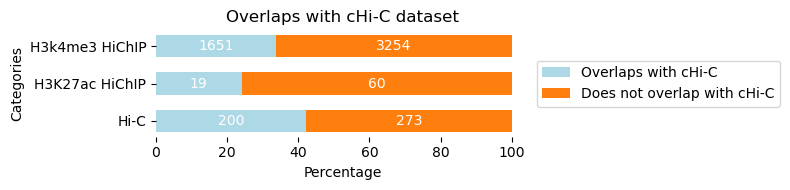

In [78]:
import matplotlib.pyplot as plt

# Data
categories = ['Hi-C', 'H3K27ac HiChIP', 'H3k4me3 HiChIP']
overlap = [200, 19, 1651]
no_overlap = [273, 60, 3254]

# Calculate percentages
total_counts = [o + n for o, n in zip(overlap, no_overlap)]
overlap_percent = [o / t * 100 for o, t in zip(overlap, total_counts)]
no_overlap_percent = [n / t * 100 for n, t in zip(no_overlap, total_counts)]

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 2))

bar_height = 0.6  # Further adjusted bar height to bring bars closer together
colors = ['#ADD8E6', '#FF7F0E']  # Light blue and warm orange
bar1 = ax.barh(categories, overlap_percent, bar_height, label='Overlaps with cHi-C', color=colors[0])
bar2 = ax.barh(categories, no_overlap_percent, bar_height, left=overlap_percent, label='Does not overlap with cHi-C', color=colors[1])

# Add labels and title
ax.set_ylabel('Categories')
ax.set_xlabel('Percentage')
ax.set_title('Overlaps with cHi-C dataset')

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add absolute numbers inside the bars
for i, (o, n) in enumerate(zip(overlap, no_overlap)):
    ax.text(overlap_percent[i] / 2, i, str(o), ha='center', va='center', color='white')
    ax.text(overlap_percent[i] + no_overlap_percent[i] / 2, i, str(n), ha='center', va='center', color='white')
# Remove upper and right plot outlines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Display the plot
plt.tight_layout()
plt.savefig("dataset-overlaps-stacked.pdf", format="pdf", bbox_inches = 'tight')

## Waffle chart of captured interactions

In [5]:
data = pl.read_csv("../../MPRA_analysis/CMPRA5/labeled_data_singlebinssmalleroverlap.tsv", separator="\t")
plotting_data = data.filter(pl.col("right_bin").str.contains("null").not_())


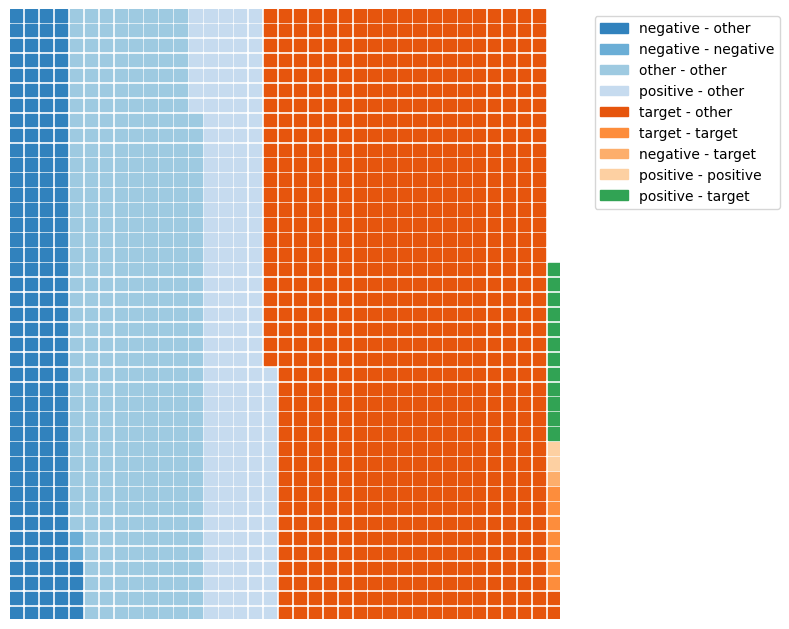

In [7]:

#fig = plt.figure(figsize=(9, 4))
waffle_dict = plotting_data.filter(
		(pl.col("adj.P.Val") < 0.05)
	).select(
		pl.col("label").value_counts()
	).unnest("label").transpose(column_names="label").to_dict(as_series=False)
waffle_data = {k: v[0]/100 for k, v in waffle_dict.items()}
plt.figure(
    FigureClass=Waffle,
    rows=41,
    values=waffle_data,
	figsize=(8, 25),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
	rounding_rule='ceil',
	cmap_name="tab20c",
)
plt.savefig("captured-interactions-waffle.pdf", format="pdf")

In [62]:
list(waffle_dict.values())

[[6], [755], [20344], [48371], [1435], [93612], [23180], [176], [138]]